# Game to Movie Video Conversion

## Main Imports

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')

import cv2
import math
import random
import natsort
import numpy as np
from matplotlib import pyplot as plt

from scipy.linalg import sqrtm
from skimage.transform import resize

from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, Input, load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Mounted at /content/drive
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-gc1ljzcb
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-gc1ljzcb
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=884f9d1d8c2de9f0d6a5db6d4b9725974263041ac9a7462b528e8c51671555e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-5x1di765/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


## Preprocess the video data


### Initialise file paths

In [3]:
main_path = '/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/'
game_load_path = main_path + 'data/game/MafiaVideogame.mp4'
game_frame_save_path = main_path + 'data/game/frames/'
game_problem_frames = [6510, 6698, 11774, 11962, 15158, 20798, 22490, 23054, 29070, 34334, 34522, 41290, 41478, 49562, 49750, 
                       65730, 65918, 66106, 69302, 73438, 73626, 74002, 80018, 80206, 87162, 89230, 92426, 96938, 103518,
                      103706, 103894, 116302, 130590, 130778, 138298, 138486, 142058, 147510, 147698, 154654, 154842, 157662,
                      166686, 166874, 173642, 173830, 180410, 192066, 192254, 196578, 202406, 202594, 207106, 214626, 221582,
                      221770, 228914, 229102]

movies_folder = main_path + 'data/movie/'
movie_frame_save_path = main_path + 'data/movie/frames/'

# data holding start frame, end frame, frame skip
movie_data = {
    "TheGodfather.mp4": (204, 12204, 30, [1074, 1104, 1134, 1164, 1194]),
    "TheIrishman.mp4": (75, 23275, 58, [12603, 12661, 12719]),
    "TheSopranos.mp4": (80, 51280, 128, [9424, 11472, 27984, 28112, 28240, 48848])
}

### Write frames from video files

In [ ]:
def write_frames(video_path, save_path, problem_frames, start_frame, end_frame, frame_skip, counter):
    
    # initialise frame capturing
    vidcap = cv2.VideoCapture(video_path)
    vidcap.set(1, start_frame)
    success, image = vidcap.read()
    frame_number = start_frame
    
    while success and frame_number < end_frame:

        # save frames as images, capturing every frame_skip frames
        cv2.imwrite(save_path + '%d.jpg' % counter, image)
        frame_number += frame_skip
        counter += 1
        
        if frame_number in problem_frames:
            original_frame_number = frame_number
            random_frame = random.randint(start_frame, end_frame)
            vidcap.set(1, random_frame)
            frame_number = original_frame_number
        else:
            vidcap.set(1, frame_number)
        success, image = vidcap.read()

### Read frames from game file

In [ ]:
write_frames(game_load_path, game_frame_save_path, game_problem_frames, 6510, 232110, 188, counter=1)

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/game/MafiaVideogame.mp4


### Read frames from movie files

In [ ]:
counter = 1
for movie_name, frame_data in movie_data.items():
    
    movie_load_path = movies_folder + movie_name
    start_frame, end_frame, frame_skip, movie_problem_frames = frame_data[0], frame_data[1], frame_data[2], frame_data[3]
    write_frames(movie_load_path, movie_save_path, movie_problem_frames, start_frame, end_frame, frame_skip, counter)
    counter += 400

/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheGodfather.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheIrishman.mp4
/content/drive/My Drive/University Work/Year 4/Advanced Computer Vision/data/movie/TheSopranos.mp4


### Set train/test sizes and paths

In [4]:
game_frame_train_path = main_path + 'data/frame_to_frame/game_train/'
game_frame_test_path = main_path + 'data/frame_to_frame/game_test/'

movie_frame_train_path = main_path + 'data/frame_to_frame/movie_train/'
movie_frame_test_path = main_path + 'data/frame_to_frame/movie_test/'

frame_data_length = len(os.listdir(game_frame_save_path))
frame_train_size = int(0.8 * frame_data_length)
frame_test_size = int(0.2 * frame_data_length)

game_frame_filenames = natsort.natsorted(os.listdir(game_frame_save_path))
movie_frame_filenames = natsort.natsorted(os.listdir(movie_frame_save_path))

print("Frame Training Set Size: ", frame_train_size)
print("Frame Testing Set Size:  ", frame_test_size)

Frame Training Set Size:  960
Frame Testing Set Size:   240


### Function to split the data into folders

In [ ]:
def split_data(size, data, save_path, new_save_path):
    
    for i in range(size[0], size[1]):

        image_name = data[i]
        image_path = save_path + image_name

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        cv2.imwrite(new_save_path + image_name, image)

### Splitting the data

In [ ]:
# split game frame data
split_data((0, frame_train_size), game_frame_filenames, game_frame_save_path, game_frame_train_path)
split_data((frame_train_size, data_length), game_frame_filenames, game_frame_save_path, game_frame_test_path)

# split movie frame data
split_data((0, frame_train_size), movie_data_filenames, movie_save_path, movie_frame_train_path)
split_data((frame_train_size, data_length), movie_data_filenames, movie_save_path, movie_frame_test_path)

### Load the data into an array

In [5]:
def load_images(path, size):
    
    data_list = list()
    
    for filename in os.listdir(path):
        
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    
    return np.asarray(data_list)

### Save the data

In [ ]:
image_size = (256, 256)
game_frame_train_data = load_images(game_frame_train_path, image_size)
movie_frame_train_data = load_images(movie_frame_train_path, image_size)

np.savez_compressed(main_path + 'data/game2movie_frame.npz', game_frame_train_data, movie_frame_train_data)
print('Saved dataset')

Saved dataset


## Evaluation

### Load frame testing data

In [ ]:
image_size = (256, 256)
game_frame_test_data = load_images(game_frame_test_path, image_size)
movie_frame_test_data = load_images(movie_frame_test_path, image_size)
print(game_frame_test_data.shape, movie_frame_test_data.shape)

(240, 256, 256, 3) (240, 256, 256, 3)


### Load face testing data

In [ ]:
image_size = (128, 128)
game_face_test_data = load_images(game_face_test_path, image_size)
movie_face_test_data = load_images(movie_face_test_path, image_size)
print(game_face_test_data.shape, movie_face_test_data.shape)

(116, 128, 128, 3) (86, 128, 128, 3)


### Predict frames for dataset

In [6]:
def get_predicted_dataset(test_path, image_size, model):

    predicted_frames_list = []

    for filename in os.listdir(test_path):

        # load, resize, and predict
        frame = load_image(test_path + filename, image_size)
        fake_frame = model.predict(frame)

        # save to array
        fake_frame_array = img_to_array(fake_frame[0])
        predicted_frames_list.append(fake_frame_array)
        
    return np.asarray(predicted_frames_list)

### Scale an array of images to a new size

In [7]:
def scale_images(images, new_shape):

    images_list = list()

    for image in images:

        # resize with nearest neighbor interpolation and store
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)

    return np.asarray(images_list)

### Frechet Inception Distance (FID) Calculator

In [8]:
def calculate_fid(model, images1, images2):
    
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # calculate sum squared difference between means and sqrt of product between cov
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

### Compute FID score for dataset

In [9]:
def get_FID_score(dataset1, dataset2):

    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    print('Loaded', dataset1.shape, dataset2.shape)

    # convert integer to floating point values
    dataset1_float = dataset1.astype('float32')
    dataset2_float = dataset2.astype('float32')

    # resize images
    dataset1_scaled = scale_images(dataset1_float, (299, 299, 3))
    dataset2_scaled = scale_images(dataset2_float, (299, 299, 3))
    print('Scaled', dataset1_scaled.shape, dataset2_scaled.shape)

    # pre-process images
    dataset1_preprocessed = preprocess_input(dataset1_scaled)
    dataset2_preprocessed = preprocess_input(dataset2_scaled)

    # calculate fid
    fid = calculate_fid(model, dataset1_preprocessed, dataset2_preprocessed)
    print('FID: %.3f' % fid)
    return fid

In [10]:
def calculate_PSNR(dataset1, dataset2):

    # convert integer to floating point values
    dataset1_float = dataset1.astype('float32')
    dataset2_float = dataset2.astype('float32')

    # resize images
    total_psnr = 0

    for i in range(0, dataset1_float.shape[0]):

        original = dataset1_float[i]
        generated = dataset2_float[i]

        mse = np.mean((original - generated) ** 2)
        if mse == 0:  # MSE is zero means no noise is present in the signal .
                      # Therefore PSNR have no importance.
            psnr = 100
        else:
            max_pixel = 255.0
            psnr = 20 * math.log10(max_pixel / math.sqrt(mse))

        total_psnr += psnr

    average_psnr = total_psnr/dataset1_float.shape[0]
    return average_psnr

### Single image load function

In [11]:
def load_image(filename, size):

    # load and resize the image and convert to numpy array
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)

    # transform in a sample and scale from [0,255] to [-1,1]
    pixels = np.expand_dims(pixels, 0)
    pixels = (pixels - 127.5) / 127.5

    return pixels

cust = {'InstanceNormalization': InstanceNormalization}

### Translate a sample of images to the opposite domain and display them

In [12]:
def display_results(generator, image_size, test_path, name, sample_size):

    test_sample = random.sample(os.listdir(test_path), sample_size)
    fake_frame_list = []

    for filename in test_sample:
        test_frame = load_image(test_path + str(filename), image_size)
        fake_frame = generator.predict(test_frame)
        fake_frame_list.append(fake_frame)

    fig = plt.figure(figsize=(24, 8))
    columns = sample_size
    rows = 2

    for i in range(1, columns*rows + 1):

        ax = fig.add_subplot(rows, columns, i)

        if i < 6:
            filename = str(test_sample[i - 1])
            frame = load_image(test_path + filename, image_size)
            ax.title.set_text(name + filename)
        else:
            frame = fake_frame_list[i - 6]
            ax.title.set_text('Fake' + name + str(test_sample[i - 6]))

        frame = (frame + 1) / 2.0
        plt.imshow(frame[0])

    plt.show()

## CycleGAN Model

### Discriminator

In [ ]:
def define_discriminator(image_shape):

    # weight initialisation and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # Convolution-64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution-512
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # get patch output and define model
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)

    # compile model and return
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001, beta_1=0.5), loss_weights=[0.5])
    return model

### Resnet Block

In [ ]:
def resnet_block(n_filters, input_layer):

    init = RandomNormal(stddev=0.02)     # weight initialization

    # first convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)

    # concatenate merge channel-wise with input layer and return
    g = Concatenate()([g, input_layer])
    return g

### Generator

In [ ]:
def define_generator(image_shape, n_resnet=6):

    # weight initialization and fetch image input
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)

    # d64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d128
    g = Conv2D(128, (7,7), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # create resnet blocks
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)

    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)

    # define model and return
    model = Model(in_image, out_image)
    return model

### Composite Model for Generator Training with Adversarial and Cycle loss

In [ ]:
def define_composite_model(generator_1, discriminator, generator_2, image_shape):
    
    # ensure the model we're updating is trainable
    generator_1.trainable = True

    # mark discriminator and other generator model as not trainable
    discriminator.trainable = False
    generator_2.trainable = False

    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = generator_1(input_gen)
    output_d = discriminator(gen1_out)

    # identity element
    input_id = Input(shape=image_shape)
    output_id = generator_1(input_id)

    # forward cycle
    output_f = generator_2(gen1_out)

    # backward cycle
    gen2_out = generator_2(input_id)
    output_b = generator_1(gen2_out)

    # define model graph and Adam optimiser
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)

    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

### Load and prepare training images

In [ ]:
def load_real_samples(filename):

    # load the dataset and unpack arrays
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']

    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    return [X1, X2]

### Select batch of random samples and return images and target

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):

    # choose random instances and retrieve selected images
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

### Generate batch of images and return images and targets

In [ ]:
def generate_fake_samples(generator, dataset, patch_shape):

    # generate fake instance and create 'fake' class labels (0)
    X = generator.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

### Save the generators

In [ ]:
def save_models(step, generator_game_to_movie, generator_movie_to_game):

    # save the first generator model
    filename1 = 'face_medium_d_g2m_%03d.h5' % (step+1)
    generator_game_to_movie.save(main_path + '/models/face_to_face/' + filename1)

    # save the second generator model
    filename2 = 'face_medium_d_m2g_%03d.h5' % (step+1)
    generator_movie_to_game.save(main_path + '/models/face_to_face/' + filename2)

    print('>Saved: %s and %s' % (filename1, filename2))

### Plot a summary of the performance

In [ ]:
def summarize_performance(step, generator, trainX, name, n_samples=5):

    # select a sample of input images and generate translated images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(generator, X_in, 0)

    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0

    # plot real images
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])

    # plot translated image
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    
    # save plot to file
    filename1 = main_path + '/results/' + 'face_medium_d_%s_%03d.png' % (name, (step+1))
    plt.savefig(filename1)

### Update the image pool for fake images

In [ ]:
def update_image_pool(pool, images, max_size=50):

    selected = list()   # initialise selected image list

    for image in images:

        if len(pool) < max_size:

            # stock the pool
            pool.append(image)
            selected.append(image)

        elif random.random() < 0.5:

            # use image, but don't add it to the pool
            selected.append(image)

        else:

            # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image

    # return as array
    return np.asarray(selected)

### Training loop

In [ ]:
def train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset, augmented):

    # define properties of the training run and determine the output square shape of the discriminator
    epochs, batch_size, = 300, 32
    patch_size = discriminator_game.output_shape[1]

    # unpack dataset and prepare image pool for fakes
    game_train, movie_train = dataset
    poolA, poolB = list(), list()

    # augment data by horizontal flipping, random zooming, and brightness change
    if augmented:
        datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5, 1.5], zoom_range=[0.7, 1.3])
        game_iterator = datagen.flow(game_train, batch_size=batch_size)
        movie_iterator = datagen.flow(movie_train, batch_size=batch_size)

    # calculate the number of batches per training epoch
    batches_per_epoch = int(len(game_train) / batch_size)
    print("Training for", epochs, "epochs on a batch size of", batch_size, "with", batches_per_epoch, "batches per epoch")

    for epoch in range(1, epochs + 1):
        for batch in range(batches_per_epoch):

            # select a batch of non-augmented real samples
            if not augmented:

                X_realA, y_realA = generate_real_samples(game_train, batch_size, patch_size)
                X_realB, y_realB = generate_real_samples(movie_train, batch_size, patch_size)

            # select a batch of augmented real samples
            else:

                X_realA = game_iterator.next()
                y_realA = np.ones((batch_size, patch_size, patch_size, 1))

                X_realB = movie_iterator.next()
                y_realB = np.ones((batch_size, patch_size, patch_size, 1))

            # generate a batch of fake samples
            X_fakeA, y_fakeA = generate_fake_samples(generator_movie_to_game, X_realB, patch_size)
            X_fakeB, y_fakeB = generate_fake_samples(generator_game_to_movie, X_realA, patch_size)

            # update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            # update generator B->A via adversarial and cycle loss
            g_loss2, _, _, _, _  = composite_movie_to_game.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

            # update discriminator for A -> [real/fake]
            discriminator_game_real_loss = discriminator_game.train_on_batch(X_realA, y_realA)
            discriminator_game_fake_loss = discriminator_game.train_on_batch(X_fakeA, y_fakeA)

            # update generator A->B via adversarial and cycle loss
            g_loss1, _, _, _, _ = composite_game_to_movie.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

            # update discriminator for B -> [real/fake]
            discriminator_movie_real_loss = discriminator_movie.train_on_batch(X_realB, y_realB)
            discriminator_movie_fake_loss = discriminator_movie.train_on_batch(X_fakeB, y_fakeB)
        
        # output losses after every epoch
        print('> Epoch %d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %\
              (epoch, discriminator_game_real_loss, discriminator_game_fake_loss, discriminator_game_real_loss, discriminator_movie_fake_loss, g_loss1, g_loss2))

        # evaluate and save the model intermittently
        if epoch % 5 == 0:
            summarize_performance(epoch, generator_game_to_movie, game_train, 'gametomovie')  # plot game -> movie translation
            summarize_performance(epoch, generator_movie_to_game, movie_train, 'movietogame')  # plot movie -> game translation
            save_models(epoch, generator_game_to_movie, generator_movie_to_game)

## Train on the frame dataset

Loaded dataset with shape: (960, 256, 256, 3) (960, 256, 256, 3)
Training for 50 epochs on a batch size of 4 with 240 batches per epoch
> Epoch 1, dA[0.030,0.070] dB[0.030,0.061] g[10.901,11.397]
> Epoch 2, dA[0.078,0.020] dB[0.078,0.053] g[10.260,11.182]
> Epoch 3, dA[0.024,0.011] dB[0.024,0.042] g[10.364,10.139]
> Epoch 4, dA[0.074,0.056] dB[0.074,0.049] g[10.558,12.214]
> Epoch 5, dA[0.048,0.051] dB[0.048,0.047] g[9.240,8.629]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


>Saved: original_frame_g2m_006.h5 and original_frame_m2g_006.h5
> Epoch 6, dA[0.021,0.023] dB[0.021,0.013] g[7.993,8.521]
> Epoch 7, dA[0.027,0.034] dB[0.027,0.041] g[7.203,6.674]
> Epoch 8, dA[0.037,0.090] dB[0.037,0.021] g[7.887,6.789]
> Epoch 9, dA[0.031,0.131] dB[0.031,0.032] g[5.758,5.301]
> Epoch 10, dA[0.049,0.055] dB[0.049,0.071] g[5.610,5.365]
>Saved: original_frame_g2m_011.h5 and original_frame_m2g_011.h5
> Epoch 11, dA[0.014,0.044] dB[0.014,0.031] g[5.969,4.703]
> Epoch 12, dA[0.052,0.054] dB[0.052,0.041] g[4.725,5.009]
> Epoch 13, dA[0.016,0.037] dB[0.016,0.098] g[5.215,5.291]
> Epoch 14, dA[0.009,0.007] dB[0.009,0.021] g[5.287,5.664]
> Epoch 15, dA[0.046,0.088] dB[0.046,0.030] g[5.883,5.545]
>Saved: original_frame_g2m_016.h5 and original_frame_m2g_016.h5
> Epoch 16, dA[0.010,0.048] dB[0.010,0.045] g[4.157,4.229]
> Epoch 17, dA[0.094,0.138] dB[0.094,0.111] g[3.878,3.938]
> Epoch 18, dA[0.041,0.008] dB[0.041,0.026] g[3.819,3.844]
> Epoch 19, dA[0.055,0.061] dB[0.055,0.013] g

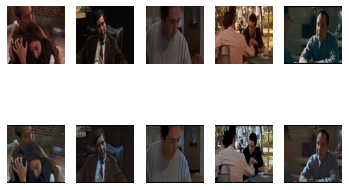

In [ ]:
# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movie_frame.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset, augmented=False)

## Frame-to-Frame Results

### Load game-to-movie frame model and display its results

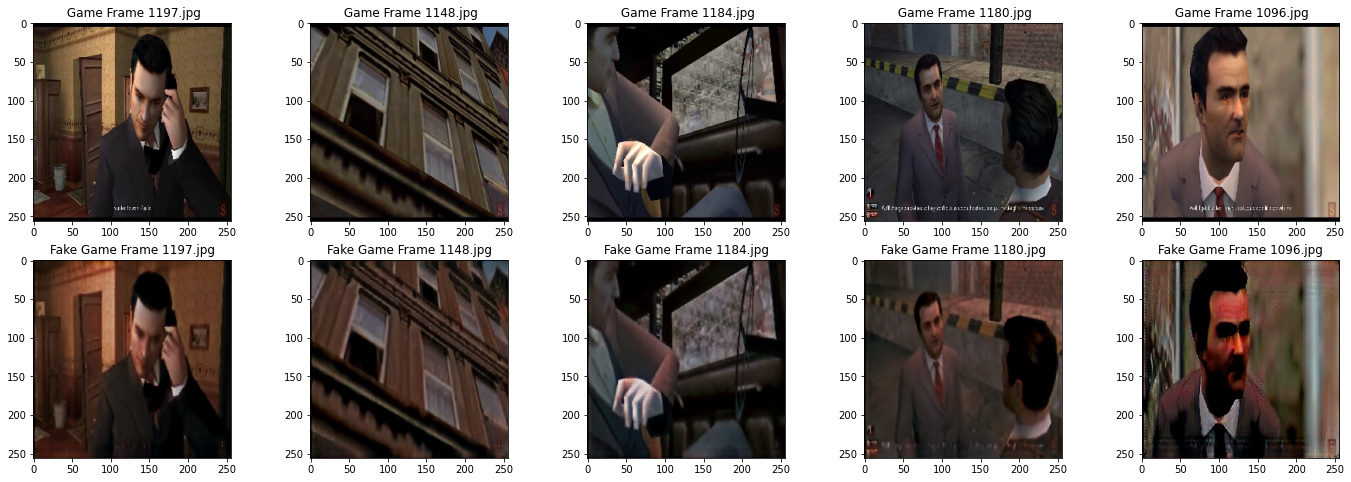

In [ ]:
game_to_movie_frame_model_path = main_path + 'models/frame_to_frame/g2m_051.h5'
game_to_movie_frame_model = load_model(game_to_movie_frame_model_path, cust)

image_size = (256, 256)
game_test_name = ' Game Frame '
display_results(game_to_movie_frame_model, image_size, game_frame_test_path, game_test_name, 5)

### Load movie-to-game frame model and display its results

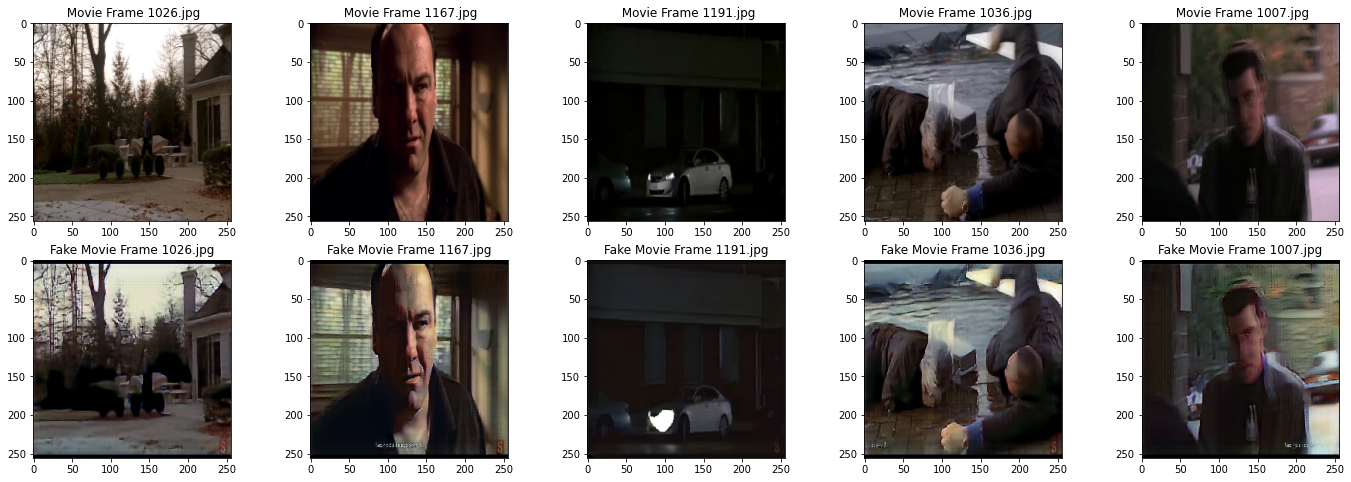

In [ ]:
movie_to_game_frame_model_path = main_path + 'models/frame_to_frame/m2g_051.h5'
movie_to_game_frame_model = load_model(movie_to_game_frame_model_path, cust)

image_size = (256, 256)
movie_test_name = ' Movie Frame '
display_results(movie_to_game_frame_model, image_size, movie_frame_test_path, movie_test_name, 5)

### Compute FID score for real movie frames to generated movie frames

In [ ]:
image_size = (256, 256)
generated_movie_dataset = get_predicted_dataset(game_frame_test_path, image_size, game_to_movie_frame_model).astype('float32')
get_FID_score(movie_frame_test_data, generated_movie_dataset)

Loaded (240, 256, 256, 3) (240, 256, 256, 3)
Scaled (240, 299, 299, 3) (240, 299, 299, 3)
FID: 483.859


483.8592927171726

### Compute PSNR for real game frames to frames generated from games

In [ ]:
image_size = (256, 256)
generated_movie_dataset = get_predicted_dataset(game_frame_test_path, image_size, game_to_movie_frame_model).astype('float32')
calculate_PSNR(game_frame_test_data, generated_movie_dataset)

13.380664107031574

### Compute FID score for real game frames to generated game frames

In [ ]:
image_size = (256, 256)
generated_game_dataset = get_predicted_dataset(movie_frame_test_path, image_size, movie_to_game_frame_model).astype('float32')
get_FID_score(game_frame_test_data, generated_game_dataset)

Loaded (240, 256, 256, 3) (240, 256, 256, 3)
Scaled (240, 299, 299, 3) (240, 299, 299, 3)
FID: 492.773


492.7725861589985

In [ ]:
image_size = (256, 256)
generated_game_dataset = get_predicted_dataset(movie_frame_test_path, image_size, movie_to_game_frame_model).astype('float32')
calculate_PSNR(game_frame_test_data, generated_game_dataset)

13.373327875943314

## Face Detection, Extraction, and Data Setup

### Detect faces in an image

In [ ]:
face_detector = cv2.CascadeClassifier(main_path + 'data/haarcascade_frontalface_default.xml')

def detect_faces(image):

    face_list = face_detector.detectMultiScale(image, 1.1, 20)
    return list(face_list)

### Pass frames to face detector and save face outputs

In [ ]:
def extract_faces(domain_name, filenames, frame_load_path, face_save_path, problem_faces):

    num_faces = 0

    for i in range(1, len(filenames) + 1):

        frame_file_path = frame_load_path + str(i) + '.jpg'
        frame = cv2.imread(frame_file_path, cv2.IMREAD_COLOR)
        face_list = detect_faces(frame)

        if face_list:

            for j in range(0, len(face_list)):

                if (i, j) not in problem_faces:

                    (x, y, w, h) = face_list[j]
                    face = frame[y:y+h, x:x+w]
                    cv2.imwrite(face_save_path + str(i) + '_' + str(j) + '.jpg', face)

            num_faces += len(face_list)

    print("Total " + domain_name + " faces:", num_faces)

### Set face write paths

In [13]:
game_frame_load_path = main_path + 'data/game/frames/'
game_face_save_path = main_path + 'data/game/faces/'
game_problem_faces = [(26, 1), (64, 0), (98, 0), (194, 1), (247, 1), (251, 0), (317, 0), (320, 0), (320, 1), (320, 2), (324, 0), (324, 2),
                      (370, 1), (375, 1), (378, 1), (449, 0), (507, 0), (507, 2), (636, 1), (637, 1), (645, 1), (647, 0), (647, 1), (647, 2),
                      (702, 0), (721, 0), (769, 0), (774, 0), (823, 0), (979, 0), (1098, 1), (1102, 0), (1187, 0)]
game_domain_name = 'game'

movie_frame_load_path = main_path + 'data/movie/frames/'
movie_face_save_path = main_path + 'data/movie/faces/'
movie_problem_faces = [(178, 0), (300, 0), (300, 1), (300, 2), (300, 3), (300, 4), (300, 5), (300, 6), (300, 7), (604, 2), (607, 0),
                       (726, 0), (756, 0), (781, 0), (853, 2), (906, 1), (909, 0), (937, 0), (941, 0)]
movie_domain_name = 'movie'

### Compute faces for game frames and movie frames

In [ ]:
extract_faces(game_domain_name, game_frame_filenames, game_frame_load_path, game_face_save_path, game_problem_faces)
extract_faces(movie_domain_name, movie_frame_filenames, movie_frame_load_path, movie_face_save_path, movie_problem_faces)

### Set face training and testing paths

In [14]:
game_face_train_path = main_path + 'data/face_to_face/game_train/'
game_face_test_path = main_path + 'data/face_to_face/game_test/'

movie_face_train_path = main_path + 'data/face_to_face/movie_train/'
movie_face_test_path = main_path + 'data/face_to_face/movie_test/'

game_face_data_length = len(os.listdir(game_face_save_path))
game_face_train_size = int(0.8 * game_face_data_length)
game_face_test_size = int(0.2 * game_face_data_length)

movie_face_data_length = len(os.listdir(movie_face_save_path))
movie_face_train_size = int(0.8 * movie_face_data_length)
movie_face_test_size = int(0.2 * movie_face_data_length)

game_face_filenames = natsort.natsorted(os.listdir(game_face_save_path))
movie_face_filenames = natsort.natsorted(os.listdir(movie_face_save_path))

print("Game Face Training Set Size: ", game_face_train_size)
print("Game Face Testing Set Size:  ", game_face_test_size)
print("Movie Face Training Set Size:", movie_face_train_size)
print("Movie Face Testing Set Size: ", movie_face_test_size)

Game Face Training Set Size:  461
Game Face Testing Set Size:   115
Movie Face Training Set Size: 342
Movie Face Testing Set Size:  85


In [ ]:
def split_face_data(midpoint, save_path, train_save_path, test_save_path):

    directory = os.fsencode(save_path)
    counter = 0

    for file in os.listdir(directory):
    
        filename = os.fsdecode(file)
        image_path = save_path + filename
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if counter < midpoint:

            cv2.imwrite(train_save_path + filename, image)
        
        else:

            cv2.imwrite(test_save_path + filename, image)

        counter += 1

### Split faces into training and testing sets

In [ ]:
# split game face data
split_face_data(game_face_train_size, game_face_save_path, game_face_train_path, game_face_test_path)

# split movie face data
split_face_data(movie_face_train_size, movie_face_save_path, movie_face_train_path, movie_face_test_path)

### Save the face dataset

In [ ]:
image_size = (128, 128)
game_face_data = load_images(game_face_train_path, image_size)
movie_face_data = load_images(movie_face_train_path, image_size)

np.savez_compressed(main_path + 'data/game2movie_face.npz', game_face_data, movie_face_data)
print('Saved face dataset')

Saved face dataset


## Train on the face dataset

Loaded dataset with shape: (461, 128, 128, 3) (342, 128, 128, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Training for 300 epochs on a batch size of 32 with 14 batches per epoch
> Epoch 1, dA[0.418,0.308] dB[0.418,0.237] g[11.489,11.158]
> Epoch 2, dA[0.187,0.188] dB[0.187,0.166] g[11.234,10.906]
> Epoch 3, dA[0.156,0.115] dB[0.156,0.171] g[10.814,10.383]
> Epoch 4, dA[0.110,0.119] dB[0.110,0.114] g[10.900,10.271]
> Epoch 5, dA[0.104,0.100] dB[0.104,0.105] g[10.956,10.419]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


>Saved: face_medium_d_g2m_006.h5 and face_medium_d_m2g_006.h5
> Epoch 6, dA[0.126,0.127] dB[0.126,0.146] g[11.270,10.566]
> Epoch 7, dA[0.119,0.087] dB[0.119,0.105] g[10.865,10.368]
> Epoch 8, dA[0.088,0.102] dB[0.088,0.086] g[10.700,10.214]
> Epoch 9, dA[0.049,0.073] dB[0.049,0.065] g[10.959,10.598]
> Epoch 10, dA[0.072,0.065] dB[0.072,0.059] g[10.841,10.496]
>Saved: face_medium_d_g2m_011.h5 and face_medium_d_m2g_011.h5
> Epoch 11, dA[0.100,0.067] dB[0.100,0.058] g[10.392,9.999]
> Epoch 12, dA[0.057,0.120] dB[0.057,0.203] g[10.442,10.154]
> Epoch 13, dA[0.062,0.051] dB[0.062,0.069] g[11.028,10.518]
> Epoch 14, dA[0.062,0.045] dB[0.062,0.049] g[10.426,9.943]
> Epoch 15, dA[0.061,0.039] dB[0.061,0.037] g[10.171,10.138]
>Saved: face_medium_d_g2m_016.h5 and face_medium_d_m2g_016.h5
> Epoch 16, dA[0.054,0.057] dB[0.054,0.046] g[10.278,10.219]
> Epoch 17, dA[0.059,0.039] dB[0.059,0.026] g[9.762,9.539]
> Epoch 18, dA[0.051,0.044] dB[0.051,0.067] g[9.199,8.997]
> Epoch 19, dA[0.041,0.039] dB[

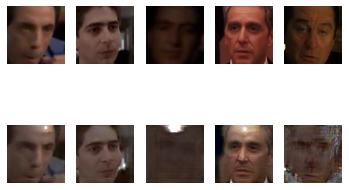

In [ ]:
# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movie_face.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset, augmented=False)

## Face-to-Face Results

### Load game-to-movie face model and display its results



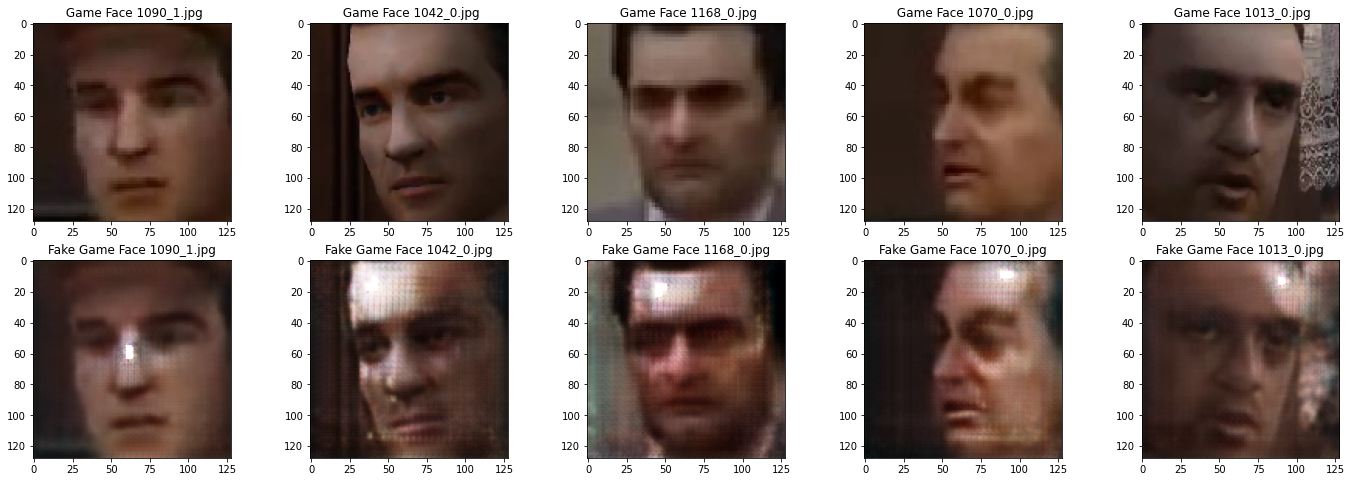

In [ ]:
game_to_movie_face_model_path = main_path + 'models/face_to_face/face_medium_d_g2m_301.h5'
game_to_movie_face_model = load_model(game_to_movie_face_model_path, cust)

image_size = (128, 128)
game_test_name = ' Game Face '
display_results(game_to_movie_face_model, image_size, game_face_test_path, game_test_name, 5)

### Load movie-to-game face model and display its results

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


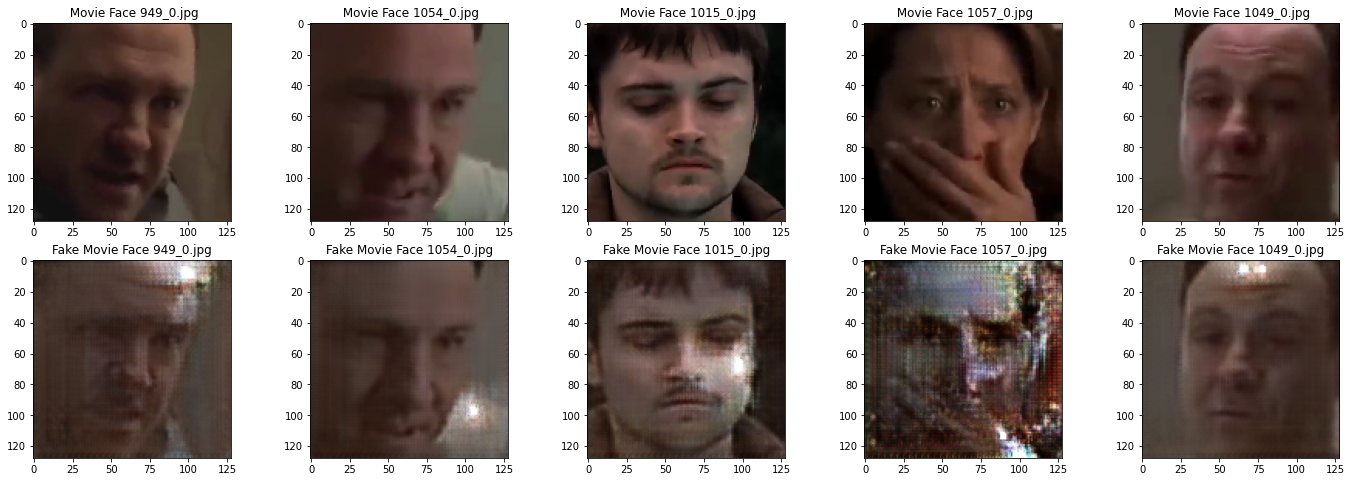

In [ ]:
movie_to_game_face_model_path = main_path + 'models/face_to_face/face_medium_d_m2g_301.h5'
movie_to_game_face_model = load_model(movie_to_game_face_model_path, cust)

movie_test_name = ' Movie Face '
display_results(movie_to_game_face_model, image_size, movie_face_test_path, movie_test_name, 5)

### Compute FID score for real movie faces to generated movie faces

In [ ]:
image_size = (128, 128)
generated_movie_dataset = get_predicted_dataset(game_face_test_path, image_size, game_to_movie_face_model).astype('float32')
get_FID_score(movie_face_test_data, generated_movie_dataset)

87924736/87910968 [==============================] - 1s 0us/step
Loaded (86, 128, 128, 3) (116, 128, 128, 3)
Scaled (86, 299, 299, 3) (116, 299, 299, 3)
FID: 411.437


411.43722310078425

### Compute FID score for real games faces to generated game faces

In [ ]:
image_size = (128, 128)
generated_game_dataset = get_predicted_dataset(movie_face_test_path, image_size, movie_to_game_face_model).astype('float32')
get_FID_score(game_face_test_data, generated_game_dataset)

Loaded (116, 128, 128, 3) (86, 128, 128, 3)
Scaled (116, 299, 299, 3) (86, 299, 299, 3)
FID: 432.230


432.2302044105472

### Compute PSNR for real games frames to frames generated from games

In [ ]:
image_size = (128, 128)
generated_movie_dataset = get_predicted_dataset(game_face_test_path, image_size, game_to_movie_face_model).astype('float32')
calculate_PSNR(game_face_test_data, generated_movie_dataset)

10.92177402001515

### Compute PSNR for real movie frames to frames generated from movies

In [ ]:
image_size = (128, 128)
generated_game_dataset = get_predicted_dataset(movie_face_test_path, image_size, movie_to_game_face_model).astype('float32')
calculate_PSNR(movie_face_test_data, generated_game_dataset)

12.86947804195961

## Train on the augmented face dataset

In [ ]:
# load image data and define input shape based on the loaded dataset
dataset = load_real_samples(main_path + 'data/game2movie_face.npz')
image_shape = dataset[0].shape[1:]
print('Loaded dataset with shape:', dataset[0].shape, dataset[1].shape)

# define generators
generator_game_to_movie = define_generator(image_shape)
generator_movie_to_game = define_generator(image_shape)

# define discriminators
discriminator_game = define_discriminator(image_shape)
discriminator_movie = define_discriminator(image_shape)

# define composite models 
composite_game_to_movie = define_composite_model(generator_game_to_movie, discriminator_movie, generator_movie_to_game, image_shape)   # game -> movie -> [real/fake, game]
composite_movie_to_game = define_composite_model(generator_movie_to_game, discriminator_game, generator_game_to_movie, image_shape)   # movie -> game -> [real/fake, movie]

# train models
train(discriminator_game, discriminator_movie, generator_game_to_movie, generator_movie_to_game, composite_game_to_movie, composite_movie_to_game, dataset, augmented=True)

## Augemented Face-to-Face Results

### Load game-to-movie face model and display its results

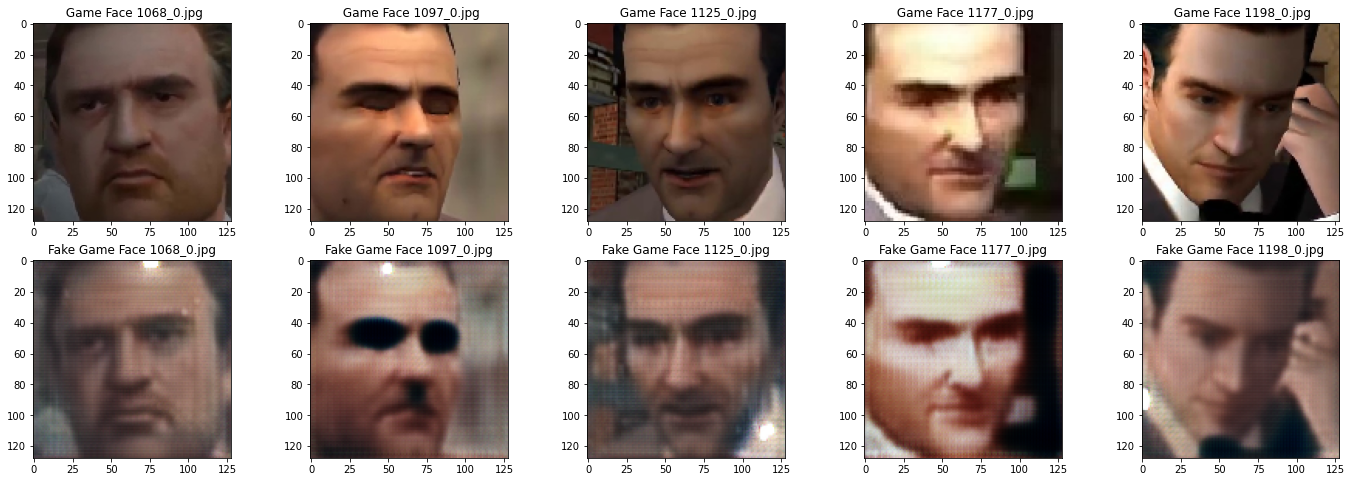

In [15]:
game_to_movie_face_augmented_model_path = main_path + 'models/face_to_face/augmented_g2m_171.h5'
game_to_movie_face_augmented_model = load_model(game_to_movie_face_augmented_model_path, cust)

image_size = (128, 128)
game_test_name = ' Game Face '
display_results(game_to_movie_face_augmented_model, image_size, game_face_test_path, game_test_name, 5)

### Load movie-to-game face model and display its results


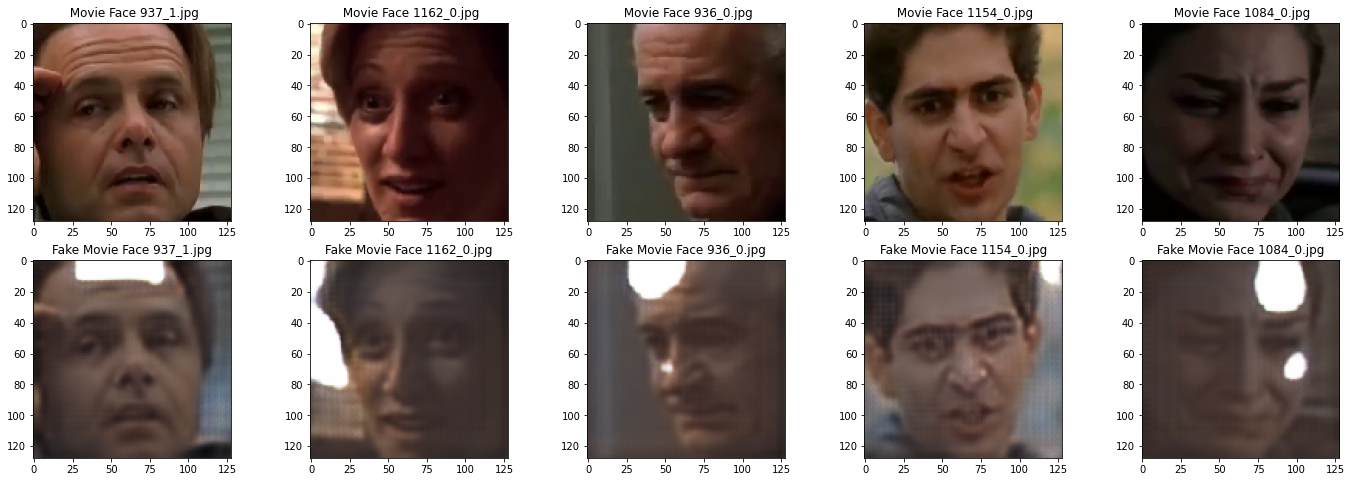

In [ ]:
movie_to_game_face_augmented_model_path = main_path + 'models/face_to_face/face_medium_augmented_m2g_151.h5'
movie_to_game_face_augmented_model = load_model(movie_to_game_face_model_path, cust)

movie_test_name = ' Movie Face '
display_results(movie_to_game_face_augmented_model, image_size, movie_face_test_path, movie_test_name, 5)

### Compute FID score for real movie faces to generated movie faces

In [ ]:
game_to_movie_face_augmented_model_path = main_path + 'models/face_to_face/augmented_g2m_171.h5'
game_to_movie_face_augmented_model = load_model(game_to_movie_face_model_path, cust)

image_size = (128, 128)
generated_movie_dataset = get_predicted_dataset(game_face_test_path, image_size, game_to_movie_face_augmented_model).astype('float32')
get_FID_score(movie_face_test_data, generated_movie_dataset)

Loaded (86, 128, 128, 3) (116, 128, 128, 3)
Scaled (86, 299, 299, 3) (116, 299, 299, 3)
FID: 411.437


411.43724978030866

### Compute FID score for real game faces to generated game faces

In [ ]:
movie_to_game_face_augmented_model_path = main_path + 'models/face_to_face/face_medium_augmented_m2g_151.h5'
movie_to_game_face_augmented_model = load_model(movie_to_game_face_model_path, cust)

image_size = (128, 128)
generated_game_dataset = get_predicted_dataset(movie_face_test_path, image_size, movie_to_game_face_augmented_model).astype('float32')
get_FID_score(game_face_test_data, generated_game_dataset)

Loaded (116, 128, 128, 3) (86, 128, 128, 3)
Scaled (116, 299, 299, 3) (86, 299, 299, 3)
FID: 426.464


426.4636785891772

### Compute PSNR for real games frames to frames generated from games

In [ ]:
image_size = (128, 128)
generated_movie_dataset = get_predicted_dataset(game_face_test_path, image_size, game_to_movie_face_augmented_model).astype('float32')
calculate_PSNR(game_face_test_data, generated_movie_dataset)

10.921774026143105

### Compute PSNR for real movie frames to frames generated from movies

In [ ]:
image_size = (128, 128)
generated_game_dataset = get_predicted_dataset(movie_face_test_path, image_size, movie_to_game_face_augmented_model).astype('float32')
calculate_PSNR(movie_face_test_data, generated_game_dataset)

12.890942018107474

## Apply augmented model to video

In [ ]:
start_frame = 139140
end_frame = 139440
to_transform_save_path = main_path + 'data/game/frames_to_transform/'

# initialise frame capturing
vidcap = cv2.VideoCapture(game_load_path)
vidcap.set(1, start_frame)
success, image = vidcap.read()
frame_number = start_frame
counter = 1

while success and frame_number < end_frame:

    # give image as input to model
    cv2.imwrite(to_transform_save_path + '%d.jpg' % counter, image)
    
    vidcap.set(1, frame_number)
    success, image = vidcap.read()
    frame_number += 1
    counter += 1

In [17]:
to_transform_save_path = main_path + 'data/game/frames_to_transform/'
dataset = get_predicted_dataset(to_transform_save_path, (128, 128), game_to_movie_face_augmented_model)

In [18]:
dataset_scaled = scale_images(dataset, (720, 1280, 3))

[0.3430099  0.3261913  0.33208507]


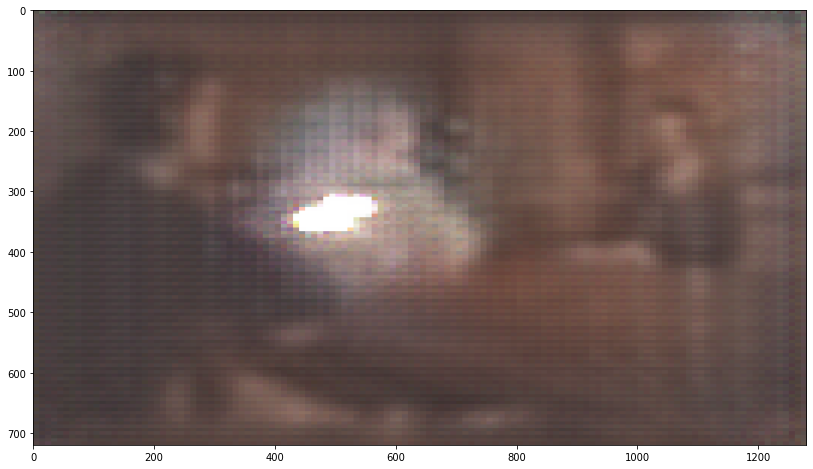

In [19]:
fig = plt.figure(figsize=(14, 8))
frame = (dataset_scaled[150] + 1) / 2.0
plt.imshow(frame)
print(frame[10][10])

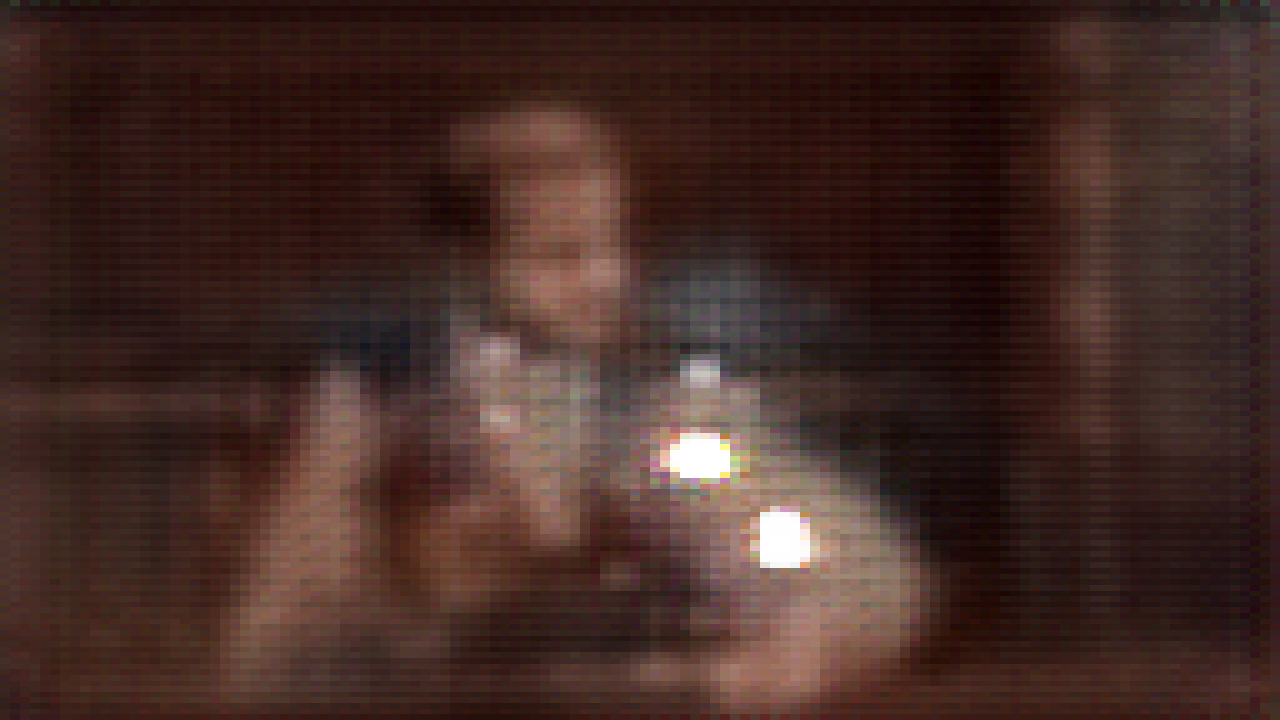

In [23]:
norm_image = cv2.normalize(dataset_scaled[0], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = norm_image.astype(np.uint8)
#plt.imshow(norm_image)
norm_image = cv2.cvtColor(norm_image, cv2.COLOR_RGB2BGR)
from google.colab.patches import cv2_imshow
cv2_imshow(norm_image)

In [24]:
frame_array = []

for i in range(0, dataset_scaled.shape[0]):

    norm_image = cv2.normalize(dataset_scaled[i], None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    norm_image = cv2.cvtColor(norm_image, cv2.COLOR_RGB2BGR)
    frame_array.append(norm_image)

video = cv2.VideoWriter(main_path + 'data/out.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30, (1280, 720))

for frame in frame_array:

    video.write(frame)

video.release()

## Saliency Map

### Preprocessing

In [ ]:
import PIL.Image

def load_sal_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

def show_image(image, grayscale, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)

img_path = main_path + 'data/doberman.png'
img = load_sal_image(img_path)

In [ ]:
import keras.backend as K

class SaliencyMask(object):
    """Base class for saliency masks. Alone, this class doesn't do anything."""
    def __init__(self, model, output_index=0):
        """Constructs a SaliencyMask.
        Args:
            model: the keras model used to make prediction
            output_index: the index of the node in the last layer to take derivative on
        """
        pass

    def get_mask(self, input_image):
        """Returns an unsmoothed mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        """Returns a mask that is smoothed with the SmoothGrad method.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):
    r"""A SaliencyMask class that computes saliency masks with a gradient."""

    def __init__(self, model, output_index=0):
        # Define the function to compute the gradient
        input_tensors = [model.input,        # placeholder for input image tensor
                         K.learning_phase(), # placeholder for mode (train or test) tense
                        ]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    def get_mask(self, input_image):
        """Returns a vanilla gradient mask.
        Args:
            input_image: input image with shape (H, W, 3).
        """
        
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value, 0])[0][0]

        return gradients

In [ ]:
from keras.applications.vgg16 import VGG16

from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

model = VGG16(weights='imagenet')
model.compile(loss='mean_squared_error', optimizer='adam')

vanilla = GradientSaliency(model)

### Got em

In [ ]:
img_path = main_path + 'data/face_to_face/game_test/1197_0.jpg'
img = load_sal_image(img_path)
new_image = resize(img, (224, 224), 0)

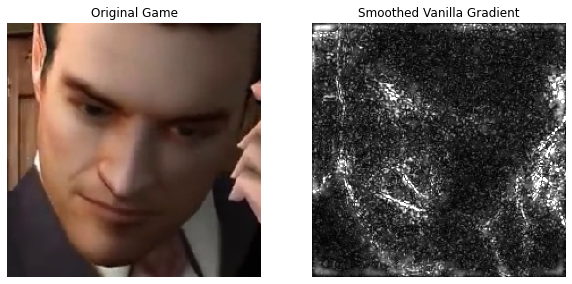

In [ ]:
plt.figure(figsize=(10, 10))

show_image(new_image, grayscale=False, ax=plt.subplot('121'), title='Original Game')

mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')

In [ ]:
img_path = main_path + 'data/face_to_face/game_test/1028_0.jpg'
img = load_sal_image(img_path)
new_image = resize(img, (224, 224), 0)

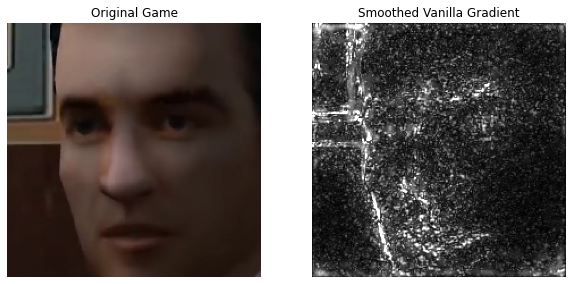

In [ ]:
plt.figure(figsize=(10, 10))

show_image(new_image, grayscale=False, ax=plt.subplot('121'), title='Original Game')

mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')

In [ ]:
img_path = main_path + 'data/face_to_face/game_test/1044_0.jpg'
img = load_sal_image(img_path)
new_image = resize(img, (224, 224), 0)

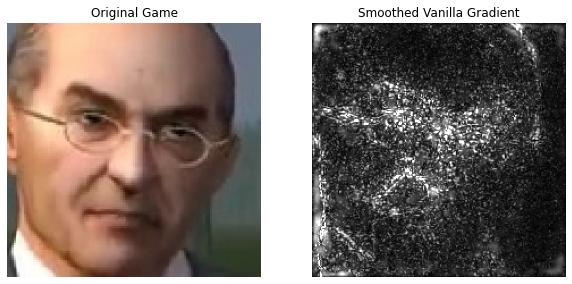

In [ ]:
plt.figure(figsize=(10, 10))

show_image(new_image, grayscale=False, ax=plt.subplot('121'), title='Original Game')

mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')

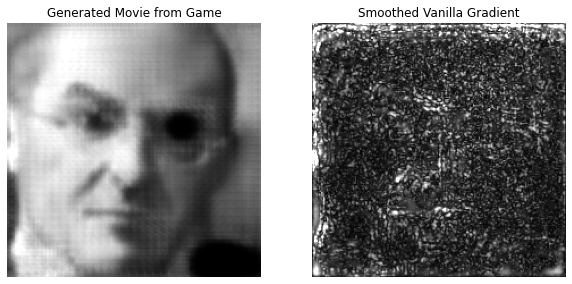

In [ ]:
plt.figure(figsize=(10, 10))
to_pred_img = load_image(main_path + 'data/face_to_face/game_test/1044_0.jpg', (128, 128))
new_img = game_to_movie_face_augmented_model.predict(to_pred_img)
frame = (new_img + 1) / 2.0

show_image(frame[0], grayscale=True, ax=plt.subplot('121'), title='Generated Movie from Game')
new_image = resize(frame[0], (224, 224), 0)
mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')

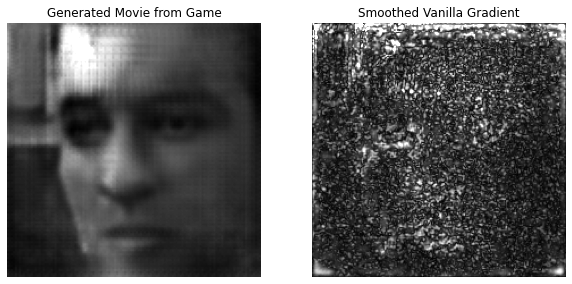

In [ ]:
plt.figure(figsize=(10, 10))
to_pred_img = load_image(main_path + 'data/face_to_face/game_test/1028_0.jpg', (128, 128))
new_img = game_to_movie_face_augmented_model.predict(to_pred_img)
frame = (new_img + 1) / 2.0

show_image(frame[0], grayscale=True, ax=plt.subplot('121'), title='Generated Movie from Game')
new_image = resize(frame[0], (224, 224), 0)
mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')

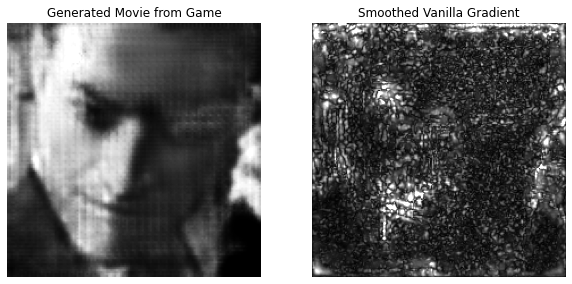

In [ ]:
plt.figure(figsize=(10, 10))
to_pred_img = load_image(main_path + 'data/face_to_face/game_test/1197_0.jpg', (128, 128))
new_img = game_to_movie_face_augmented_model.predict(to_pred_img)
frame = (new_img + 1) / 2.0

show_image(frame[0], grayscale=True, ax=plt.subplot('121'), title='Generated Movie from Game')
new_image = resize(frame[0], (224, 224), 0)
mask = vanilla.get_smoothed_mask(new_image)
show_image(mask, grayscale=True, ax=plt.subplot('122'), title='Smoothed Vanilla Gradient')